-----
# SciML2024 Workshop
Neural Operators

Tutorial # 3

Nov. 2024, University of Campinas

By Jassem Abbasi, jassem.abbasi@uis.no, https://jcabbasi.github.io/


----

Based on a code from GideonIlung GitHub use, https://github.com/GideonIlung/DeepONet



## Tutorial goals

## By the End of This Tutorial, You Should Be Able To:
- Understand the fundamental concepts of **neural operators** and their applications.
- Grasp the theoretical foundation of **DeepONet**, including its branch and trunk network architecture.
- Implement a **DeepONet model** to approximate nonlinear operators between function spaces.
- Apply DeepONet to solve practical problems, such as **partial differential equations (PDEs)** or other function mapping tasks.
- Analyze and interpret the performance of DeepONet in terms of accuracy, efficiency, and generalization.


## Task overview

In this tutorial, we will explore the implementation and application of **DeepONet**, a neural operator designed to act as an integral operator.




In [5]:
#IMPORTS
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch



# Introduction to Neural Operators and DeepONet

## Neural Operators
Neural operators are a class of machine learning models designed to **approximate operators**, which are mappings between function spaces. Unlike traditional neural networks that operate on finite-dimensional inputs (e.g., vectors), neural operators learn relationships between entire functions, making them particularly suitable for solving problems in scientific computing and physics-informed machine learning.

### Key Features:
1. **Infinite-Dimensional Inputs**:
   Neural operators generalize the notion of neural networks to function spaces, enabling them to process inputs of varying dimensions and discretizations.
   
2. **Applications**:
   - Partial Differential Equations (PDEs)
   - Functional approximations
   - Weather prediction and fluid dynamics

3. **Efficiency**:
   Neural operators can learn surrogate models for complex systems, significantly reducing computational costs compared to traditional numerical solvers.

---

## DeepONet: Deep Operator Networks
DeepONet (Deep Operator Network) is one of the pioneering architectures in the field of neural operators. It is specifically designed to learn nonlinear operators, enabling efficient approximations of mappings between input and output functions.

### Theory Behind DeepONet:
DeepONet is inspired by the universal approximation theorem for operators, which states that any continuous nonlinear operator can be approximated by a neural network. The architecture consists of two main components:
1. **Branch Network**:
   Encodes the input function \( u(x) \) at selected sensor points.
   
2. **Trunk Network**:
   Encodes the target location \( y \) in the domain where the output is evaluated.

The output of DeepONet is computed as:
\[
G(u)(y) = \sum_{i=1}^p b_i(u) t_i(y)
\]
where \( b_i(u) \) are the outputs of the branch network, and \( t_i(y) \) are the outputs of the trunk network. Together, they represent the operator \( G(u)(y) \), mapping input functions \( u(x) \) to outputs \( y \).

### Advantages:
- **Scalability**: Handles high-dimensional input and output spaces.
- **Generalization**: Learns mappings for varying input and output discretizations.
- **Applications**:
  - Solving PDEs efficiently
  - Modeling complex systems in physics, biology, and engineering

---

Neural operators like DeepONet provide a foundation for next-generation scientific computing, offering speed and flexibility that traditional numerical solvers cannot achieve. By leveraging modern advancements in machine learning, they unlock the potential to tackle previously intractable problems in computational science.


In [ ]:
#getting the data#
# The dataset is curtesy of the DeepXDE library (Lu et al.), was used in a
# https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html

#loading the data#
data_train = np.load("antiderivative_aligned_train.npz",allow_pickle=True)
data_test = np.load("antiderivative_aligned_test.npz",allow_pickle=True)
print('successfully loaded')

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
#IMPORTS#
import torch
import torch.nn as nn
import numpy as np
class DeepONet(nn.Module):
    """
        Implementation of the Deep Operator Network
    """

    def __init__(self,n_branch:int,width:int,depth:int,p:int,act,n_trunk:int=1):
        """
            Creates the DON using the following parameters

            Parameters:
            n_branch (int) : the input size of the branch network
            n_trunk  (int) : the input size of the trunk network
            depth    (int) : number of layers in each network 
            width.   (int) : number of nodes at each layer
            p        (int) : output dimension of network
            act            : the activation function to be used
        """
        super(DeepONet, self).__init__()

        #creating the branch network#
        self.branch_net = MLP(input_size=n_branch,hidden_size=width,num_classes=p,depth=depth,act=act)
        self.branch_net.float()

        #creating the trunk network#
        self.trunk_net = MLP(input_size=n_trunk,hidden_size=width,num_classes=p,depth=depth,act=act)
        self.trunk_net.float()
        
        self.bias = nn.Parameter(torch.ones((1,)),requires_grad=True)
    
    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

    
    def forward(self,x_branch_,x_trunk_):
        """
            evaluates the operator

            x_branch : input_function
            x_trunk : point evaluating at

            returns a scalar
        """

        x_branch = self.convert_np_to_tensor(x_branch_)
        x_trunk = self.convert_np_to_tensor(x_trunk_)
        
        branch_out = self.branch_net.forward(x_branch)
        trunk_out = self.trunk_net.forward(x_trunk,final_act=True)

        output = branch_out @ trunk_out.t() + self.bias
        return output

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, depth,act):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        
        #the activation function#
        self.act = act 

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        # Hidden layers
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_size, num_classes))
        
    def forward(self, x,final_act=False):
        for i in range(len(self.layers) - 1):
            x = self.act(self.layers[i](x))
        x = self.layers[-1](x)  # No activation after the last layer

        if final_act == False:
            return x
        else:
            return torch.relu(x)
        

In [22]:
#IMPORTS
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np


#training algorithm#
def train_DON(model:DeepONet,x_branch,x_trunk,y_,lr:float=0.001,batch_size=32,epochs=100,log=True):
    """
        trains a deep operator network

        Parameters:
            model    (DeepONet)     : the network to be trained
            x_branch (torch.tensor) : the branch input data
            x_trunk  (torch.tensor) : the trunk input data
            y        (torch.tensor) : the targets
    """

    #creating datahandler#
    dataset = Datahandler(x_branch,x_trunk,y_) 
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True) 

    #using standard MSE loss#
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #getting trunk data#
    trunk = convert_np_to_tensor(x_trunk)

    #creating training loop#
    for epoch in range(epochs):
        losses = []
        for branch,_,y in dataloader:
            
            #removing previous gradients#
            optimizer.zero_grad()

            #forward pass through model#
            output = model.forward(branch,trunk)
            loss = criterion(output,y)

            # Backward pass
            loss.backward()

            #calculate avg loss across batches#
            losses.append(loss.item())

            # Update parameters
            optimizer.step()

        avg_loss = np.mean(losses)

        if epoch % 100 == 0: 
            print(f"loss at epoch {epoch}:{avg_loss}") 

def convert_np_to_tensor(array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array

class Datahandler(Dataset):
    """
        Handles the training Dataset 
        for the DeepONet
    """
    def __init__(self, x_branch_, x_trunk_, y_):

        x_branch = self.convert_np_to_tensor(x_branch_)
        x_trunk = self.convert_np_to_tensor(x_trunk_)
        y = self.convert_np_to_tensor(y_)

        self.x_batch = x_branch
        self.x_trunk = x_trunk
        self.y = y

    def convert_np_to_tensor(self,array):
        if isinstance(array, np.ndarray):
            # Convert NumPy array to PyTorch tensor
            tensor = torch.from_numpy(array)
            return tensor.to(torch.float32)
        else:
            return array
    
    def __len__(self):
        return len(self.y)  # Assuming x_batch and x_trunk have the same length as y

    def __getitem__(self, index):
        return self.x_batch[index,:], self.x_trunk, self.y[index,:]

# Deep O Net Example

will use the deep o network to approximate the integral operator 

$$\frac{dv}{dx} = u(x)$$
$$v(0)=0$$

$u(x)$ is the input into the network. the output is $v(x)$. i.e $$v(x) = \int u(x) dx$$ 

In [8]:
#formatting the training data#
branch_train = data_train['X'][0]
trunk_train =data_train['X'][1] 
Y_train = data_train['y']

print(f"branch shape (n_function,n_grid_points): {branch_train.shape}")
print(f"trunk shape (n_grid_points,1): {trunk_train.shape}")
print(f"output shape (n_function,n_grid_points) : {Y_train.shape}")

branch shape (n_function,n_grid_points): (150, 100)
trunk shape (n_grid_points,1): (100, 1)
output shape (n_function,n_grid_points) : (150, 100)


In [9]:
#formatting the test data#
branch_test = data_test['X'][0]
trunk_test =data_test['X'][1] 
Y_test = data_test['y']

print(f"branch shape (n_function,n_grid_points): {branch_test.shape}")
print(f"trunk shape (n_grid_points,1): {trunk_test.shape}")
print(f"output shape (n_function,n_grid_points) : {Y_test.shape}")

branch shape (n_function,n_grid_points): (1000, 100)
trunk shape (n_grid_points,1): (100, 1)
output shape (n_function,n_grid_points) : (1000, 100)


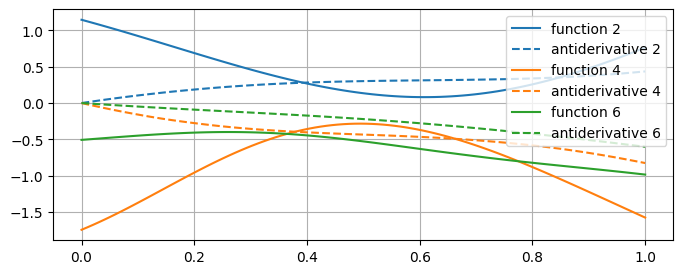

In [29]:
color_palette = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf'   # Teal
]

ih = [2, 4, 6]

plt.figure(figsize=(8, 3))

for i, color in zip(ih, color_palette):
    xspan = trunk_train.flatten()
    plt.plot(xspan, branch_train[i, :], label=f'function {i}', linestyle='-', color=color)  # Solid line
    plt.plot(xspan, Y_train[i, :], '--', label=f'antiderivative {i}', color=color)  # Dashed line with same color

plt.grid()
plt.legend(loc='best')

In [19]:
#creating model#
model = DeepONet(n_branch=100,width=40,depth=1,p=40,act=torch.relu)

In [23]:
#training model#
train_DON(model,branch_train,trunk_train,Y_train,epochs=1000,log=True)

loss at epoch 0:0.004254023174871691
loss at epoch 100:2.210948077845387e-05
loss at epoch 200:0.0008708056760951876
loss at epoch 300:0.00028103210497647523
loss at epoch 400:4.589010859490372e-05
loss at epoch 500:0.00019630664464784787
loss at epoch 600:0.000521497247973457
loss at epoch 700:1.314198161708191e-05
loss at epoch 800:3.812254435615614e-05
loss at epoch 900:5.0867692334577444e-05


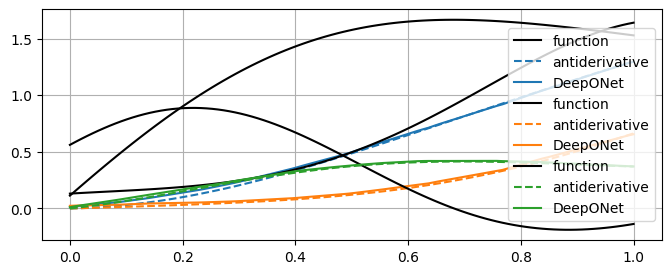

In [32]:
#validating the model#
i = 9 #function index#

ih = [2, 4, 6]

plt.figure(figsize=(8, 3))

for i, color in zip(ih, color_palette):
    xspan = trunk_train.flatten()
    xspan = trunk_test.flatten()
    u = model.forward(branch_test[i,:],trunk_test).detach()
    u = u.numpy().flatten()
    plt.plot(xspan,branch_test[i,:],'k',label='function')
    plt.plot(xspan,Y_test[i,:],'--',label='antiderivative',color=color)
    plt.plot(xspan,u,label='DeepONet',color=color)
plt.grid()
plt.legend(loc='best')

